# Pontifícia Universidade Católica do Paraná
## Disciplina: Técnicas de Machine Learning
#### Conteúdo complementar da Semana 5 - Séries Temporais

A ideia deste notebook é a de realizarmos o processo de treinamento e previsão de séries temporais.

Como comentamos nos últimos notebooks, sempre que tiver uma dúvida sobre alguma função em específico encorajamos que busque nas documentações. O exercício de sempre consultar a documentação é parte do dia-a-dia de um profissional de TI e, portanto, vale a pena colocarmos em prática quando possível.

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose # utilizado para realizar a decomposição de séries temporais

from prophet import Prophet # utilizado para séries temporais
from sklearn.model_selection import train_test_split # utilizado para o split entre treinamento e teste
from sklearn.ensemble import RandomForestRegressor # random forest para regressão
from pmdarima.arima import auto_arima # utilizado para treinar o AutoARIMA

import pandas as pd # importando o pandas para manipularmos os datasets
import numpy as np # importando o numpy para realizar manipulações de vetores
import matplotlib.pyplot as plt # utilizado para a geração de gráficos
import seaborn as sns # utilizado para a geração de gráficos

In [4]:
# o seasonal_decompose usa o tamanho padrão de imagem do Matplotlib, o que acaba sendo pequeno demais para o nosso caso
# logo, estamos alterando o tamanho padrão dos gráficos
plt.rc('figure', figsize=(10, 8))

## Leitura da base de dados
O dataset ```df_dolar``` contém todas as cotações do dólar entre 2021-05-12 e 2021-06-11.

In [6]:
df_dolar = pd.read_csv('dolar.tsv', sep='\t').sort_values(by='Data') # ordenando primeiro pela data mais antiga
df_dolar['Data'] = pd.to_datetime(df_dolar['Data'])
df_dolar

,Data,Cotacao
279,2020-05-12,5.8856
278,2020-05-13,5.8852
277,2020-05-14,5.8115
276,2020-05-15,5.8554
275,2020-05-18,5.7190
...,...,...
4,2021-06-07,5.0451
3,2021-06-08,5.0325
2,2021-06-09,5.0621
1,2021-06-10,5.0552


## Decomposição de séries temporais
Para que a decomposição dê certo, o ```seasonal_decompose``` espera que o índice seja a data e que o dataset esteja ordenado da data mais antiga para a data mais recente. Logo, faremos as devidas alterações para que isto aconteça utilizando o ```set_index``` (para que o índice passe a ser a coluna Data) e ```sort_index``` (para ordenar da maneira correta).

Depois, vamos mostrar dois exemplos de decomposição: um utilizando somente abril de 2021 e parte de maio de 2021 (que utilizamos na unidade) e outro contendo todo o histórico. Para todo o histórico, estamos informando uma periodicidade de 7 dias. Compare os resultados entre ambos. Se possível, teste diferentes valores no ```period```. O que acontecerá se você mudar para 5? 14? 30? 90?

In [8]:
df_dolar_decompose = df_dolar.copy()
df_dolar_decompose = df_dolar_decompose.set_index('Data').sort_index()
df_dolar_decompose

,Cotacao
Data,
2020-05-12,5.8856
2020-05-13,5.8852
2020-05-14,5.8115
2020-05-15,5.8554
2020-05-18,5.7190
...,...
2021-06-07,5.0451
2021-06-08,5.0325
2021-06-09,5.0621


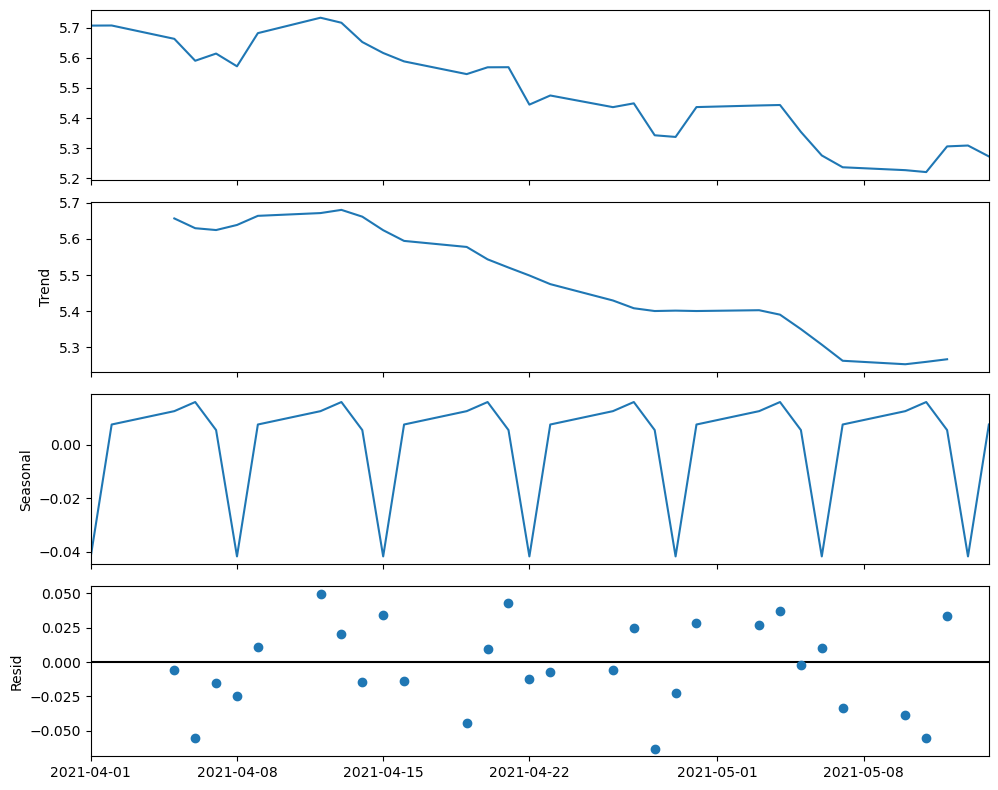

In [9]:
fig = seasonal_decompose(df_dolar_decompose[(df_dolar_decompose.index>='2021-04-01') & (df_dolar_decompose.index<='2021-05-14')]).plot()

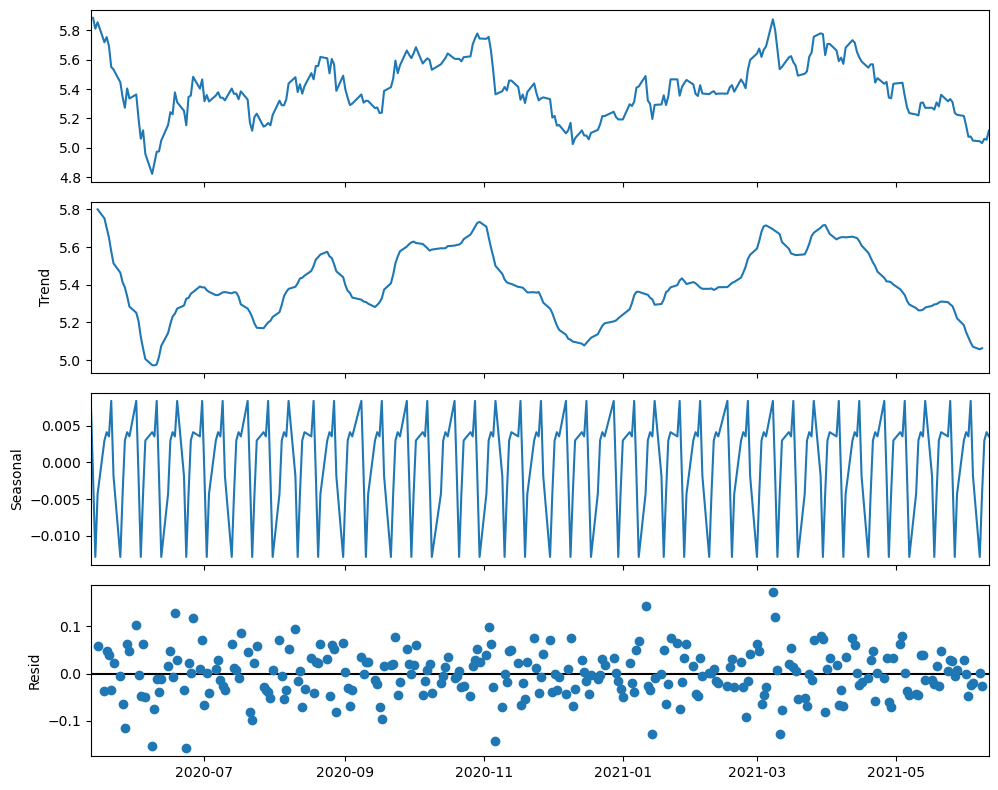

In [10]:
fig = seasonal_decompose(df_dolar_decompose, period=7).plot()

## Regressão

Vamos criar um modelo de regressão para esta base. Como vimos que há uma sazonalidade a cada sete dias (aproximadamente), usaremos um ***sliding window*** de ```7``` dias. Faremos isto com a ajuda da função <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html">shift</a>, do Pandas.

In [12]:
df_dolar_ml = df_dolar

for lag in range(1, 8):
    col = f'Cotacao_-{lag}'
    df_dolar_ml[col] = df_dolar_ml['Cotacao'].shift(lag)

Para fins de demonstração, também incluiremos duas novas colunas: uma, utilizando a ***média móvel*** dos últimos ```7``` dias com a função <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html">rolling</a>, do Pandas, combinado com a função <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html">mean</a>. A combinação dos dois basicamente captura os últimos ```7``` valores e calcula a média deles. O ```shift(1)``` desloca em um dia para que a cotação do dia atual não seja calculada em conjunto.

Finalmente, o <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html">dayofweek</a> obtém o dia da semana.

In [14]:
display('Gerando a média móvel.')
df_dolar_ml['MediaMovel7Dias'] = df_dolar_ml['Cotacao'].shift(1).rolling(7).mean()
df_dolar_ml['DiaSemana'] = df_dolar_ml['Data'].dt.dayofweek
df_dolar_ml

'Gerando a média móvel.'

,Data,Cotacao,Cotacao_-1,Cotacao_-2,Cotacao_-3,Cotacao_-4,Cotacao_-5,Cotacao_-6,Cotacao_-7,MediaMovel7Dias,DiaSemana
279,2020-05-12,5.8856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
278,2020-05-13,5.8852,5.8856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
277,2020-05-14,5.8115,5.8852,5.8856,NaN,NaN,NaN,NaN,NaN,NaN,3
276,2020-05-15,5.8554,5.8115,5.8852,5.8856,NaN,NaN,NaN,NaN,NaN,4
275,2020-05-18,5.7190,5.8554,5.8115,5.8852,5.8856,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-07,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.2252,5.2383,5.147714,0
3,2021-06-08,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.2252,5.120114,1
2,2021-06-09,5.0621,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.092586,2
1,2021-06-10,5.0552,5.0621,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.070429,3


Precisamos remover agora as colunas com dados nulos (no caso, estes primeiros dias com esta <em>"escadinha"</em> de ```NaN```).

In [16]:
df_dolar_ml = df_dolar_ml.dropna()
df_dolar_ml

,Data,Cotacao,Cotacao_-1,Cotacao_-2,Cotacao_-3,Cotacao_-4,Cotacao_-5,Cotacao_-6,Cotacao_-7,MediaMovel7Dias,DiaSemana
272,2020-05-21,5.5507,5.6925,5.7540,5.7190,5.8554,5.8115,5.8852,5.8856,5.800457,3
271,2020-05-22,5.5338,5.5507,5.6925,5.7540,5.7190,5.8554,5.8115,5.8852,5.752614,4
270,2020-05-25,5.4461,5.5338,5.5507,5.6925,5.7540,5.7190,5.8554,5.8115,5.702414,0
269,2020-05-26,5.3450,5.4461,5.5338,5.5507,5.6925,5.7540,5.7190,5.8554,5.650214,1
268,2020-05-27,5.2733,5.3450,5.4461,5.5338,5.5507,5.6925,5.7540,5.7190,5.577300,2
...,...,...,...,...,...,...,...,...,...,...,...
4,2021-06-07,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.2252,5.2383,5.147714,0
3,2021-06-08,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.2252,5.120114,1
2,2021-06-09,5.0621,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.2172,5.092586,2
1,2021-06-10,5.0552,5.0621,5.0325,5.0451,5.0495,5.0775,5.0754,5.1509,5.070429,3


### Treinamento e teste

Agora, para o treinamento consideramos todos os dias com a exceção dos últimos 30 dias. Como a base de dados já está ordenada por data, separaremos as últimas 30 linhas para o teste com a função <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.iloc.html">iloc</a>. Vamos usar o ```RandomForestRegressor``` para o treinamento. A coluna da ```Data``` será removida já que o algoritmo poderia não ser treinado adequadamente com esta coluna. Compare as previsões.

In [18]:
X = df_dolar_ml.drop(['Cotacao', 'Data'], axis=1)
y = df_dolar_ml['Cotacao']

X_train = X.iloc[:-30]
y_train = y.iloc[:-30]

X_test = X.iloc[-30:]
y_test = y.iloc[-30:]

In [19]:
model_rf = RandomForestRegressor(random_state=0).fit(X_train, y_train)
df_previsoes_rf = pd.DataFrame(np.array([y_test.values, model_rf.predict(X_test)]).T, columns=['Real', 'Previsão (Random Forest)'])
df_previsoes_rf

,Real,Previsão (Random Forest)
0,5.4420,5.413052
1,5.4435,5.404563
2,5.3542,5.418789
3,5.2760,5.372838
4,5.2368,5.353498
5,5.2272,5.253645
6,5.2208,5.237183
7,5.3061,5.220816
8,5.3090,5.324337
9,5.2728,5.346852


## Prophet

Vamos fazer a mesma previsão, mas agora via Prophet. Da mesma forma que fizemos na regressão separaremos os últimos ```30``` dias para o backtest.

In [21]:
df_dolar_ml = df_dolar.sort_values(by='Data').rename(columns={'Data': 'ds', 'Cotacao': 'y'}) # ordenando primeiro pela data mais antiga e renomeando as colunas

df_train = df_dolar_ml.iloc[:-30]
df_test = df_dolar_ml.iloc[-30:]

Para fins de teste, criaremos dois modelos do Prophet: um contendo todo o histórico e outro contendo somente os últimos ```60``` dias da base de treinamento.

Observe também os resultados que o algoritmo forneceu - as previsões estão na coluna ```yhat```. O intervalo de confiança é representado pelas colunas ```yhat_lower``` e ```yhat_upper```.

In [23]:
model_prophet_todo_historico = Prophet().fit(df_train) # treinando o Prophet
previsoes_prophet_todo_historico = model_prophet_todo_historico.predict(df_test) # gerando as predições
previsoes_prophet_todo_historico.head()

14:19:41 - cmdstanpy - INFO - Chain [1] start processing
14:19:41 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-03,5.671966,5.490729,5.821216,5.671966,5.671966,-0.014236,-0.014236,-0.014236,-0.014236,-0.014236,-0.014236,0.0,0.0,0.0,5.657730
1,2021-05-04,5.673817,5.478763,5.799497,5.673725,5.673817,-0.037414,-0.037414,-0.037414,-0.037414,-0.037414,-0.037414,0.0,0.0,0.0,5.636403
2,2021-05-05,5.675667,5.462579,5.784635,5.674603,5.676334,-0.045472,-0.045472,-0.045472,-0.045472,-0.045472,-0.045472,0.0,0.0,0.0,5.630195
3,2021-05-06,5.677517,5.459475,5.793510,5.674875,5.679369,-0.049323,-0.049323,-0.049323,-0.049323,-0.049323,-0.049323,0.0,0.0,0.0,5.628195
4,2021-05-07,5.679368,5.481248,5.808119,5.674733,5.682617,-0.033810,-0.033810,-0.033810,-0.033810,-0.033810,-0.033810,0.0,0.0,0.0,5.645557


In [24]:
model_prophet_ultimos_dois_meses = Prophet().fit(df_train.iloc[-60:]) # treinando o Prophet
previsoes_prophet_ultimos_dois_meses = model_prophet_ultimos_dois_meses.predict(df_test) # gerando as predições
previsoes_prophet_ultimos_dois_meses.head()

14:19:42 - cmdstanpy - INFO - Chain [1] start processing
14:19:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-05-03,2.985333,5.285218,5.463952,2.984812,2.985849,2.388122,2.388122,2.388122,2.388122,2.388122,2.388122,0.0,0.0,0.0,5.373455
1,2021-05-04,2.970061,5.256287,5.441234,2.968099,2.971996,2.372878,2.372878,2.372878,2.372878,2.372878,2.372878,0.0,0.0,0.0,5.342940
2,2021-05-05,2.954790,5.200687,5.381765,2.950841,2.958346,2.337880,2.337880,2.337880,2.337880,2.337880,2.337880,0.0,0.0,0.0,5.292671
3,2021-05-06,2.939519,5.178457,5.362626,2.933328,2.945299,2.329841,2.329841,2.329841,2.329841,2.329841,2.329841,0.0,0.0,0.0,5.269360
4,2021-05-07,2.924248,5.193450,5.380810,2.915366,2.933055,2.361351,2.361351,2.361351,2.361351,2.361351,2.361351,0.0,0.0,0.0,5.285599


Observe os resultados. O que observa os últimos 60 dias aparenta começar mais próximo da realidade, mas também se perde no futuro. Já o que considera todo o histórico aparenta ser bem pessimista. Na documentação do Prophet existem algumas configurações (as quais chamamos de **hiperparâmetros**) que ajudam a melhor calibrar o modelo.

Existem casos nos quais o Prophet é melhor do que um modelo de regressão ou um ARIMA, e vice-versa. Na prática, é um trabalho de testes.

In [26]:
df_previsoes_prophet = pd.DataFrame(np.array([df_test['y'].values,
                                              previsoes_prophet_todo_historico['yhat'],
                                              previsoes_prophet_ultimos_dois_meses['yhat']]).T,
                                    columns=['Real', 'Previsão (Prophet, Todo Histórico)', 'Previsão (Prophet, Últimos 60 Dias)'])
df_previsoes_prophet

,Real,"Previsão (Prophet, Todo Histórico)","Previsão (Prophet, Últimos 60 Dias)"
0,5.4420,5.657730,5.373455
1,5.4435,5.636403,5.342940
2,5.3542,5.630195,5.292671
3,5.2760,5.628195,5.269360
4,5.2368,5.645557,5.285599
5,5.2272,5.670683,5.266556
6,5.2208,5.649355,5.236041
7,5.3061,5.643147,5.185772
8,5.3090,5.641147,5.162462
9,5.2728,5.658510,5.178700


## ARIMA

Finalmente, demonstraremos um exemplo de uso do ARIMA. Para nos aproximarmos do mundo de ML ao invés de irmos para a Estatística teremos como foco o <a href="https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima-arima-auto-arima">AutoARIMA</a>, ok? Por outro lado, lembre-se: o uso do ARIMA aqui serve tão somente para um propósito informacional na disciplina. Caso tenha interesse sugerimos ler a documentação do AutoARIMA com calma.

Note que o resultado do AutoARIMA para este caso foi um ```order=(1, 0, 0)```, o que também é chamado de ```AR(1)```.

In [28]:
y_train = df_dolar['Cotacao'].iloc[:-30]
y_test = df_dolar['Cotacao'].iloc[-30:]

In [29]:
model_arima = auto_arima(y_train)
model_arima

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
df_previsoes_autoarima = pd.DataFrame(np.array([y_test.values,
                                                model_arima.predict(n_periods=30)]).T,
                                      columns=['Real', 'Previsão (AutoARIMA)'])
df_previsoes_autoarima

C:\Users\wmont\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\wmont\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Real,Previsão (AutoARIMA)
0,5.4420,5.4366
1,5.4435,5.4366
2,5.3542,5.4366
3,5.2760,5.4366
4,5.2368,5.4366
5,5.2272,5.4366
6,5.2208,5.4366
7,5.3061,5.4366
8,5.3090,5.4366
9,5.2728,5.4366


## Mostrando os resultados

Agora, vamos mostrar os resultados de cada uma das técnicas. Analise os seguintes pontos:
 - Os modelos dão previsões mais corretas para os primeiros dias (curto prazo) ou bem no futuro (longo prazo)?
 - Existem pontos fortes e pontos fracos nas previsões dos modelos?
 - Provavelmente o modelo que ficou mais próximo da realidade foi o RandomForest, mas ele sempre possui o que aconteceu no dia anterior. Já os outros modelos possuem menos informações para gerar os próximos 30 dias. Sendo assim, como alteraríamos o nosso dataset para que o RandomForest pudesse prever dois dias à frente? Ou três dias à frente? Ou mais dias à frente?
 - Será que o ARIMA teria resultados diferentes se mudássemos os seus parâmetros?

In [32]:
df_dolar.iloc[-30:]['Data'].values

array(['2021-05-03T00:00:00.000000000', '2021-05-04T00:00:00.000000000',
       '2021-05-05T00:00:00.000000000', '2021-05-06T00:00:00.000000000',
       '2021-05-07T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000',
       '2021-05-19T00:00:00.000000000', '2021-05-20T00:00:00.000000000',
       '2021-05-21T00:00:00.000000000', '2021-05-24T00:00:00.000000000',
       '2021-05-25T00:00:00.000000000', '2021-05-26T00:00:00.000000000',
       '2021-05-27T00:00:00.000000000', '2021-05-28T00:00:00.000000000',
       '2021-05-31T00:00:00.000000000', '2021-06-01T00:00:00.000000000',
       '2021-06-02T00:00:00.000000000', '2021-06-03T00:00:00.000000000',
       '2021-06-04T00:00:00.000000000', '2021-06-07T00:00:00.000000000',
       '2021-06-08T00:00:00.000000000', '2021-06-09

Para criar o gráfico usaremos a função <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.melt.html">melt</a>. Ela pegará todas as colunas de previsões e agrupará dentro de uma coluna única contendo todos os valores e outra coluna contendo os tipos dos valores.

In [34]:
# unindo as tabelas
df_previsoes = df_previsoes_rf.merge(df_previsoes_prophet, on='Real').merge(df_previsoes_autoarima, on='Real')
df_previsoes['Data'] = df_dolar.iloc[-30:]['Data'].values
df_previsoes

,Real,Previsão (Random Forest),"Previsão (Prophet, Todo Histórico)","Previsão (Prophet, Últimos 60 Dias)",Previsão (AutoARIMA),Data
0,5.4420,5.413052,5.657730,5.373455,5.4366,2021-05-03
1,5.4435,5.404563,5.636403,5.342940,5.4366,2021-05-04
2,5.3542,5.418789,5.630195,5.292671,5.4366,2021-05-05
3,5.2760,5.372838,5.628195,5.269360,5.4366,2021-05-06
4,5.2368,5.353498,5.645557,5.285599,5.4366,2021-05-07
5,5.2272,5.253645,5.670683,5.266556,5.4366,2021-05-10
6,5.2208,5.237183,5.649355,5.236041,5.4366,2021-05-11
7,5.3061,5.220816,5.643147,5.185772,5.4366,2021-05-12
8,5.3090,5.324337,5.641147,5.162462,5.4366,2021-05-13
9,5.2728,5.346852,5.658510,5.178700,5.4366,2021-05-14


In [35]:
df_previsoes = df_previsoes.melt(id_vars='Data')
df_previsoes

,Data,variable,value
0,2021-05-03,Real,5.4420
1,2021-05-04,Real,5.4435
2,2021-05-05,Real,5.3542
3,2021-05-06,Real,5.2760
4,2021-05-07,Real,5.2368
...,...,...,...
145,2021-06-07,Previsão (AutoARIMA),5.4366
146,2021-06-08,Previsão (AutoARIMA),5.4366
147,2021-06-09,Previsão (AutoARIMA),5.4366
148,2021-06-10,Previsão (AutoARIMA),5.4366


<Axes: xlabel='Data', ylabel='Cotacao'>

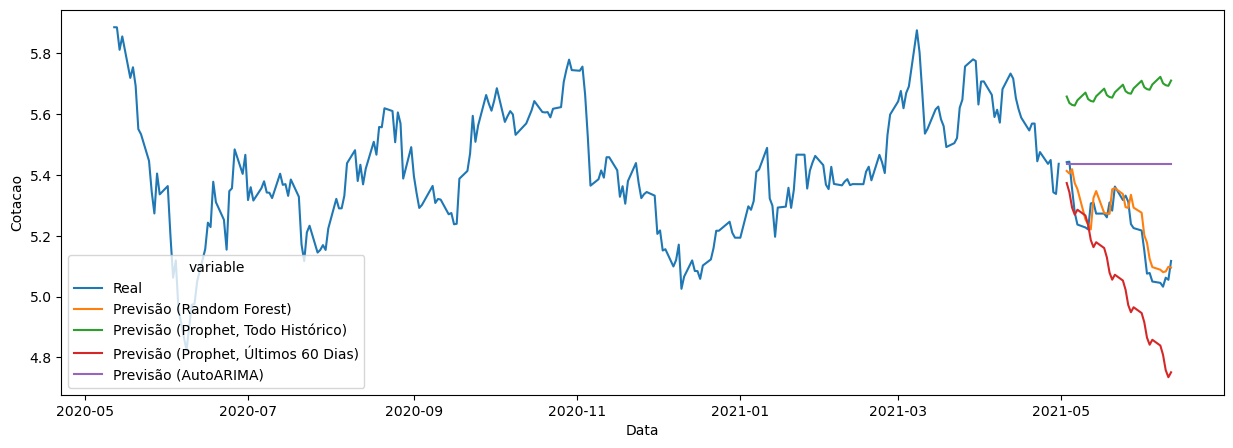

In [36]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=df_dolar.iloc[:-30], x='Data', y='Cotacao')
sns.lineplot(data=df_previsoes, x='Data', y='value', hue='variable')